this document try to make Dobkin–Kirkpatrick hierarchy visible.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import ConvexHull
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [9]:
#generate random 3D points
np.random.seed(42)
n_points = 20  #number of points in the original layer
points = np.random.randn(n_points, 3)
print(f"{n_points} random points generated")

20 random points generated


## README

### Dobkin-Kirkpatrick Hierarchy

**Dobkin-Kirkpatrick Hierarchy** is a hierarchical data structure for point location in computational geometry, introduced by David Dobkin and David Kirkpatrick in 1990. It enables efficient point location queries in 3D convex polytopes with O(log n) time complexity.

#### Algorithm Overview

The algorithm constructs a hierarchy of progressively simplified convex hulls through iterative vertex removal:

1. **Initial Layer**: Start with the convex hull of all input points
2. **Independent Set Selection**: At each iteration, identify an independent set of vertices where:
   - Each vertex has degree ≤ 8 (connected to at most 8 faces)
   - No two vertices in the set are adjacent to each other
3. **Vertex Removal**: Remove the independent set and retriangulate the resulting holes
4. **Iteration**: Repeat until only a simple polytope (e.g., tetrahedron) remains
5. **Query Processing**: Use the hierarchy to traverse from the simplest to the most complex hull

#### Key Properties

- **Logarithmic Depth**: The hierarchy has O(log n) levels
- **Independent Set Guarantee**: In any 3D convex polytope, there exists at least one vertex with degree ≤ 8
- **Efficient Updates**: The structure can be updated dynamically as points are added or removed

#### Visualization Legend

- 🔵 **Blue circles**: Vertices retained in the current layer
- ❌ **Red crosses**: Vertices removed in this iteration
- **Light blue polyhedron**: The convex hull of the current layer
- **Number labels**: Original indices of vertices for tracking

This visualization demonstrates how the algorithm progressively simplifies a 3D point set by removing low-degree vertices while maintaining the convex hull structure at each level.

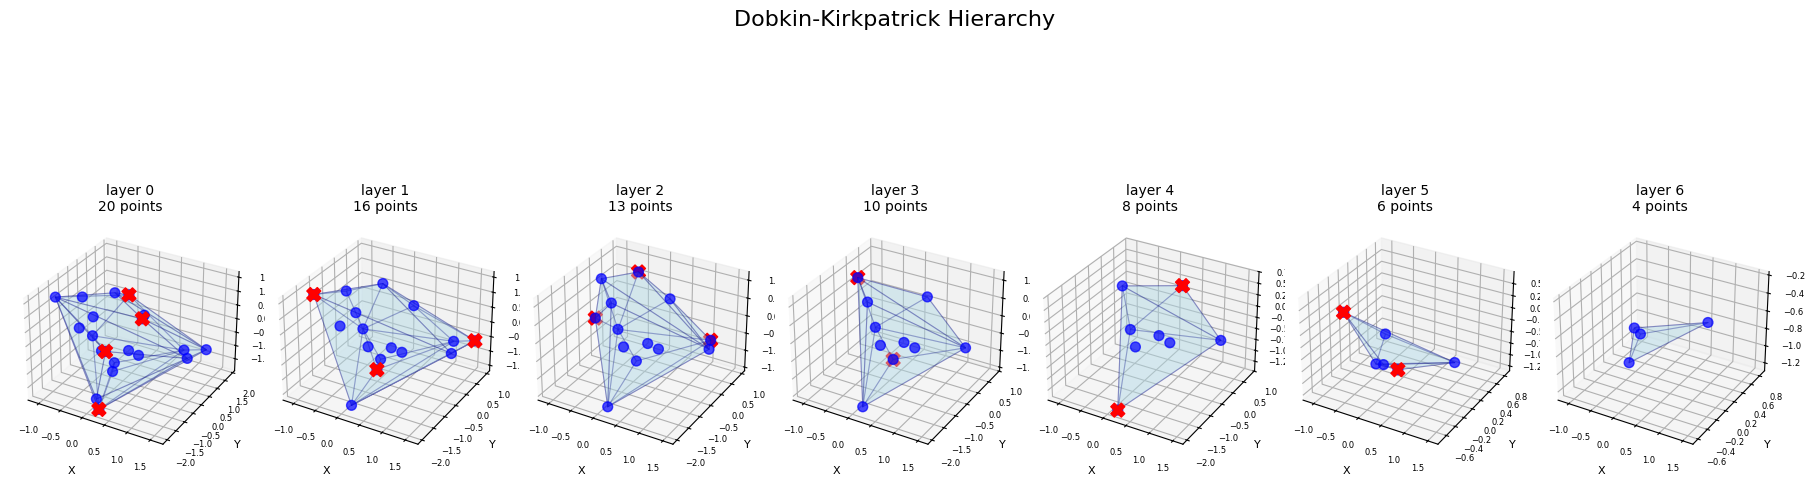

finished visualizing the hierarchy


In [14]:
#run this cell in the end to visualize the hierarchy
fig = plt.figure(figsize=(18, 6))

n_layers = len(hierarchy)
for i, layer in enumerate(hierarchy):
    ax = fig.add_subplot(1, n_layers, i+1, projection='3d')
    
    #plot the convex hull faces
    hull = layer['hull']
    points_3d = layer['points']
    
    faces = []
    for simplex in hull.simplices:
        face = [points_3d[j] for j in simplex]
        faces.append(face)
    
    poly = Poly3DCollection(faces, alpha=0.25, facecolor='lightblue', 
                            edgecolor='navy', linewidth=0.8)
    ax.add_collection3d(poly)
    
    #plot the retained points
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], 
               c='blue', s=50, marker='o', alpha=0.7)
    
    #plot the removed points
    if len(layer['removed_points']) > 0:
        removed = layer['removed_points']
        ax.scatter(removed[:, 0], removed[:, 1], removed[:, 2], 
                   c='red', s=100, marker='X', alpha=1.0)
    
    ax.set_xlabel('X', fontsize=8)
    ax.set_ylabel('Y', fontsize=8)
    ax.set_zlabel('Z', fontsize=8)
    ax.set_title(f'layer {i}\n{len(points_3d)} points', fontsize=10)
    ax.tick_params(labelsize=6)

plt.suptitle('Dobkin-Kirkpatrick Hierarchy', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("finished visualizing the hierarchy")

visualizing each layer separately...


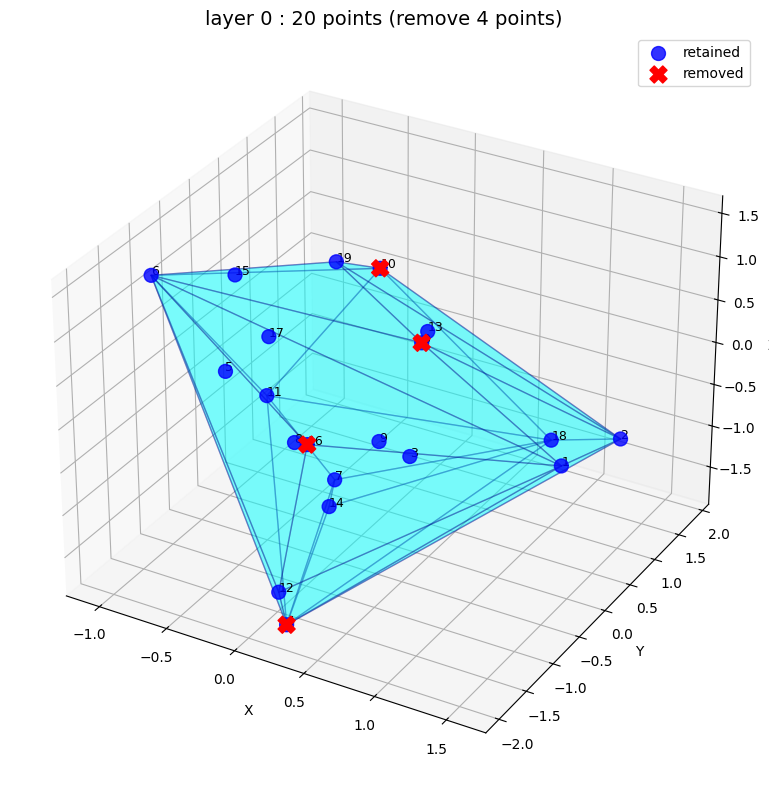

layer 0 visualization complete


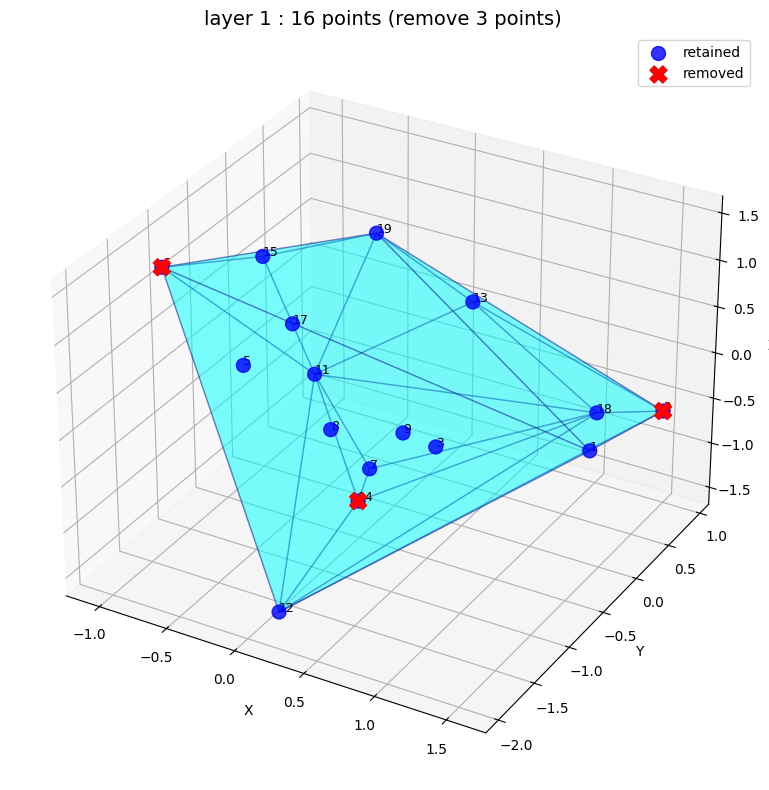

layer 1 visualization complete


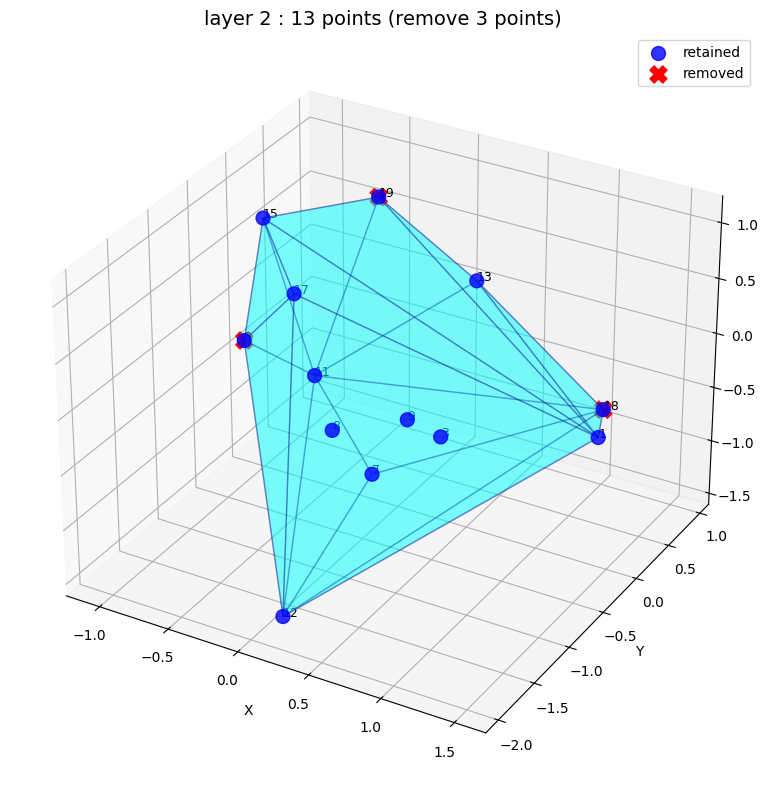

layer 2 visualization complete


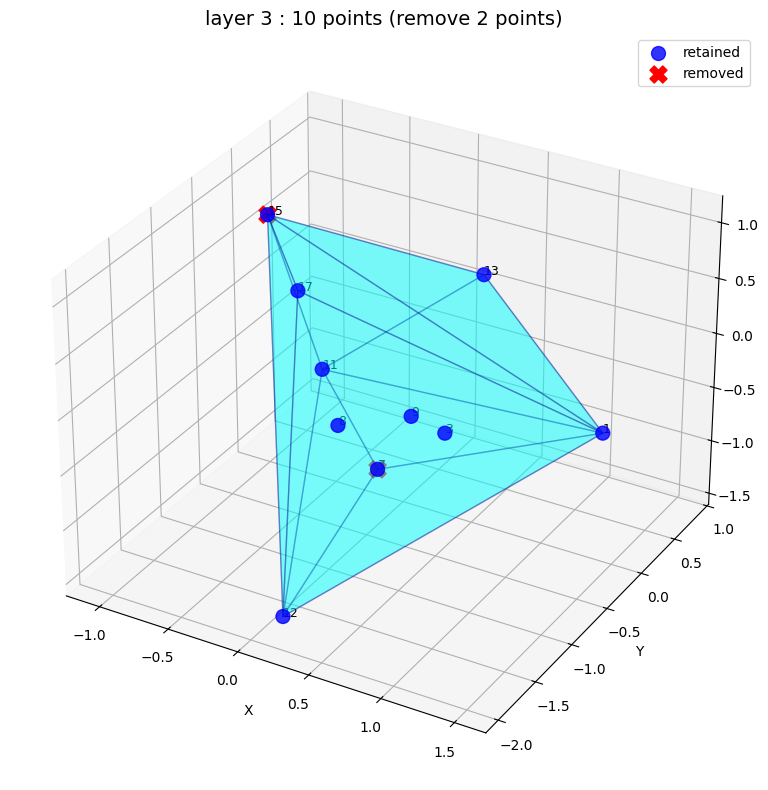

layer 3 visualization complete


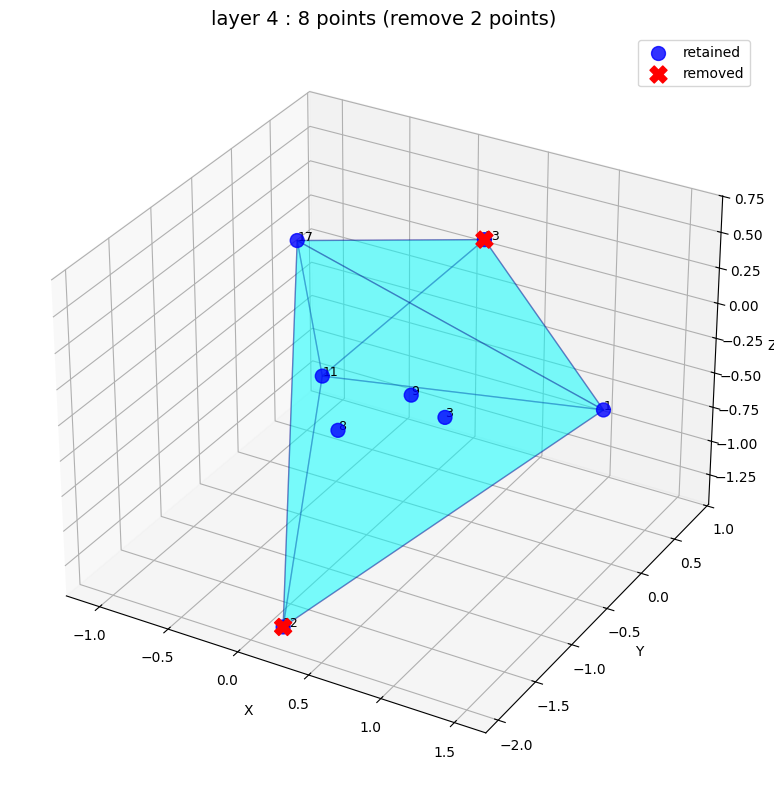

layer 4 visualization complete


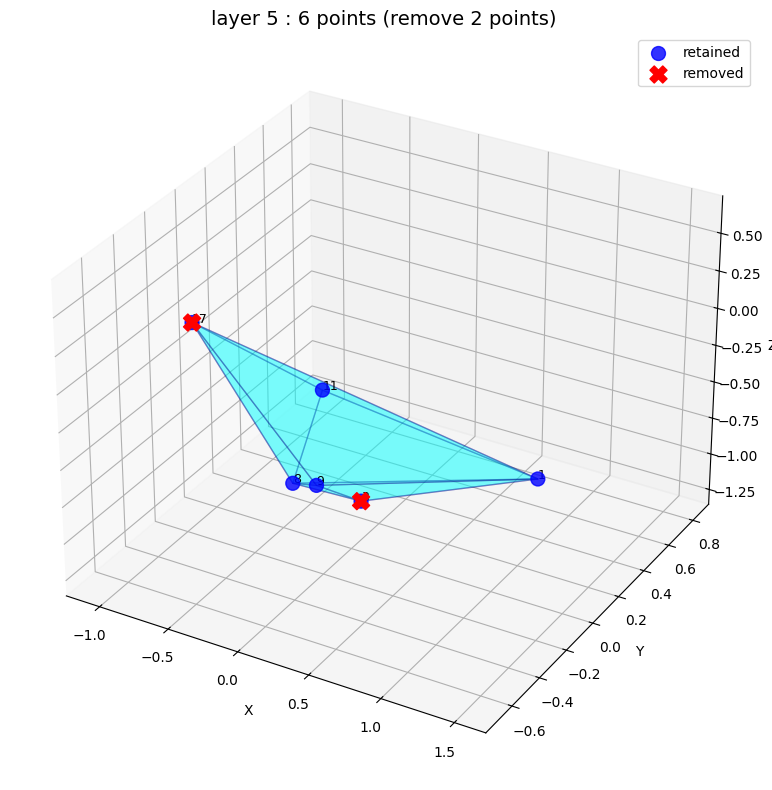

layer 5 visualization complete


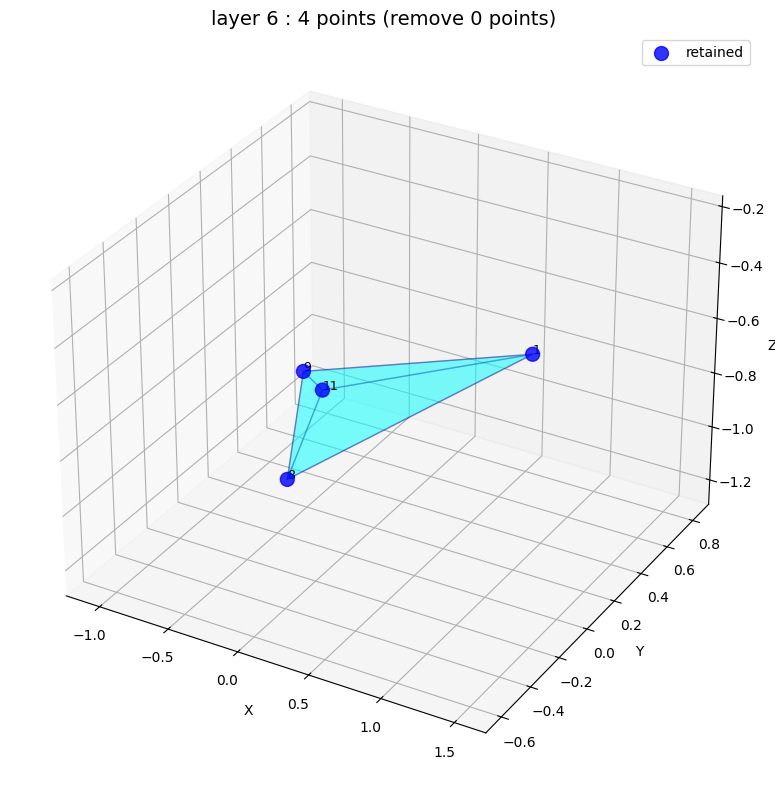

layer 6 visualization complete


In [13]:
def plot_layer(layer, original_points, layer_num, title_suffix=""):
    """plot the convex hull of a specific layer"""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the convex hull faces
    hull = layer['hull']
    points_3d = layer['points']
    
    #plot the convex hull faces
    faces = []
    for simplex in hull.simplices:
        face = [points_3d[i] for i in simplex]
        faces.append(face)
    
    poly = Poly3DCollection(faces, alpha=0.3, facecolor='cyan', edgecolor='darkblue', linewidth=1)
    ax.add_collection3d(poly)
    
    # Plot the retained points (blue)
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], 
               c='blue', s=100, marker='o', label='retained', alpha=0.8)
    
    # Plot the removed points (red)
    if len(layer['removed_points']) > 0:
        removed = layer['removed_points']
        ax.scatter(removed[:, 0], removed[:, 1], removed[:, 2], 
                   c='red', s=150, marker='X', label='removed', alpha=1.0)
    
    # Annotate the original indices of the points
    for i, idx in enumerate(layer['all_indices']):
        point = points_3d[i]
        ax.text(point[0], point[1], point[2], f'{idx}', fontsize=9)
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'layer {layer_num} : {len(points_3d)} points (remove {len(layer["removed_indices"])} points){title_suffix}', 
                 fontsize=14)
    ax.legend()
    
    plt.tight_layout()
    return fig

# Visualize each layer separately
print("visualizing each layer separately...")
for i, layer in enumerate(hierarchy):
    fig = plot_layer(layer, points, i)
    plt.show()
    print(f"layer {i} visualization complete")

In [12]:
# 构建DK hierarchy
hierarchy = dobkin_kirkpatrick_hierarchy(points)
print(f"DK Hierarchy finished with {len(hierarchy)} layers")
for i, layer in enumerate(hierarchy):
    print(f"Layer {i}: {len(layer['points'])} points, removed {len(layer['removed_indices'])} points")

DK Hierarchy finished with 7 layers
Layer 0: 20 points, removed 4 points
Layer 1: 16 points, removed 3 points
Layer 2: 13 points, removed 3 points
Layer 3: 10 points, removed 2 points
Layer 4: 8 points, removed 2 points
Layer 5: 6 points, removed 2 points
Layer 6: 4 points, removed 0 points


In [10]:
def get_vertex_degree(hull):
    """calculate the degree of each vertex in the convex hull (number of adjacent faces)"""
    vertex_degree = {}
    for simplex in hull.simplices:
        for vertex in simplex:
            if vertex not in vertex_degree:
                vertex_degree[vertex] = 0
            vertex_degree[vertex] += 1
    return vertex_degree

def find_independent_set(hull, max_degree=8):
    """
    find an independent set of vertices with degree <= max_degree
    returns: a list of vertex indices that form an independent set
    """
    vertex_degree = get_vertex_degree(hull)
    
    #find all vertices with degree <= max_degree
    low_degree_vertices = [v for v, d in vertex_degree.items() if d <= max_degree]
    
    if not low_degree_vertices:
        return []
    
    #construct adjacency list for the hull vertices
    adjacent = {v: set() for v in range(len(hull.points))}
    for simplex in hull.simplices:
        for i in range(len(simplex)):
            for j in range(i+1, len(simplex)):
                adjacent[simplex[i]].add(simplex[j])
                adjacent[simplex[j]].add(simplex[i])
    
    #find an independent set using a greedy approach
    independent_set = []
    used = set()
    
    for vertex in low_degree_vertices:
        if vertex not in used:
            independent_set.append(vertex)
            used.add(vertex)
            used.update(adjacent[vertex])
    
    return independent_set

def dobkin_kirkpatrick_hierarchy(points):
    """
    construct the Dobkin-Kirkpatrick hierarchy
    returns: a list of layers, each layer contains:
    - points: the points in this layer
    - hull: the convex hull object for this layer
    - removed_indices: the indices of points removed from the previous layer
    - removed_points: the coordinates of points removed from the previous layer
    - all_indices: the indices of all points in this layer (for reference)
    """
    hierarchy = []
    current_points = points.copy()
    current_indices = list(range(len(points)))
    
    while len(current_points) > 4:  #keep at least 4 points (a tetrahedron)
        #calculate convex hull for current layer
        try:
            hull = ConvexHull(current_points)
        except:
            break
        
        #find independent set of low-degree vertices
        independent_set = find_independent_set(hull)
        
        if not independent_set:
            #if we cannot find an independent set, it means all vertices have high degree, stop
            break
        
        #record layer info
        removed_indices = [current_indices[i] for i in independent_set]
        layer_info = {
            'points': current_points.copy(),
            'hull': hull,
            'removed_indices': removed_indices,
            'removed_points': current_points[independent_set],
            'all_indices': current_indices.copy()
        }
        hierarchy.append(layer_info)
        
        #remove independent set points for next iteration
        mask = np.ones(len(current_points), dtype=bool)
        mask[independent_set] = False
        current_points = current_points[mask]
        current_indices = [current_indices[i] for i in range(len(mask)) if mask[i]]
        
        if len(current_points) < 4:
            break
    
    # last layer
    if len(current_points) >= 4:
        try:
            hull = ConvexHull(current_points)
            layer_info = {
                'points': current_points.copy(),
                'hull': hull,
                'removed_indices': [],
                'removed_points': np.array([]),
                'all_indices': current_indices.copy()
            }
            hierarchy.append(layer_info)
        except:
            pass
    
    return hierarchy

print("DK hierarchy algorithm defined")

DK hierarchy algorithm defined
